In [59]:
import numpy as np
import pandas as pd
import torch
import re
from Constants import *
import simplejson
from Preprocessing import *
from Utils import *
from sklearn.metrics import balanced_accuracy_score, roc_auc_score,accuracy_score, precision_recall_fscore_support
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier


In [19]:
decision_model,transition_model1,transition_model2, outcome_model = load_models()
dataset = DTDataset()
decision_model

DecisionModel(
  (input_dropout): Dropout(p=0.25, inplace=False)
  (layers): ModuleList(
    (0): Linear(in_features=90, out_features=500, bias=True)
    (1): ReLU()
  )
  (batchnorm): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (relu): Softplus(beta=1, threshold=20)
  (sigmoid): Sigmoid()
  (softmax): LogSoftmax(dim=1)
  (final_opt_layer): Linear(in_features=500, out_features=20, bias=True)
  (final_imitation_layer): Linear(in_features=500, out_features=20, bias=True)
  (final_layer): Linear(in_features=40, out_features=6, bias=True)
)

In [3]:

def transition_sample(state,dataset=None):
    if dataset is None:
        dataset = DTDataset()
        
    ids = get_dt_ids(dataset.processed_df.reset_index())
    
    train_ids, test_ids = get_tt_split(dataset.processed_df.reset_index())
    
    #only train on people with  IC for state 1 since other people can't have any outcomes otherwise
    require = None
    if state == 1:
        require = Const.decisions[0] #we don't expect a state update if there is no treatment
        valid_ids = dataset.get_input_state(require=require).index.values
        train_ids = [t for t in train_ids if t in valid_ids]
        test_ids = [t for t in test_ids if t in valid_ids]
    xtrain = dataset.get_input_state(step=state,ids=train_ids,require=require)
    xtest = dataset.get_input_state(step=state,ids=test_ids,require=require)
    ytrain = dataset.get_intermediate_outcomes(step=state,ids=train_ids,require=require)
    ytest = dataset.get_intermediate_outcomes(step=state,ids=test_ids,require=require)

    xtrain = df_to_torch(xtrain)
    xtest = df_to_torch(xtest)
    ytrain = [df_to_torch(t) for t in ytrain]
    ytest= [df_to_torch(t) for t in ytest]
    return xtrain,xtest,ytrain,ytest

transition_sample(0,dataset)[-1]

[tensor([0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
         0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
         1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0.,
         0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
         0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0.,
         1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
         1., 1., 1.]),
 tensor([0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1.,
         1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1.,
         1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
     

In [4]:
def mc_metrics(yt,yp,numpy=False,is_dlt=False,is_squeezed=False):
    if not numpy:
        yt = yt.cpu().detach().numpy()
        yp = yp.cpu().detach().numpy()
    #dlt prediction (binary)
    if is_dlt:
        acc = accuracy_score(yt,yp>.5)
        if yt.sum() > 1:
            auc = roc_auc_score(yt,yp)
        else:
            auc=-1
        error = np.mean((yt-yp)**2)
        return {'accuracy': acc, 'mse': error, 'auc': auc}
    #this is a catch for when I se the dlt prediction format (encoded integer ordinal, predict as a categorical and take the argmax)
    elif yt.ndim > 1 or is_squeezed:
        try:
            bacc = balanced_accuracy_score(yt.argmax(axis=1),yp.argmax(axis=1))
        except:
            bacc = -1
        try:
            roc_micro = roc_auc_score(yt,yp,average='micro')
        except:
            roc_micro=-1
        try:
            roc_macro = roc_auc_score(yt,yp,average='macro')
        except Exception as e:
            try: 
                roc_macro = roc_auc_score(yt[:,0:2],yp[:,0:2],average='macro')
            except:
                roc_macro = -1
        try:
            roc_weighted = roc_auc_score(yt,yp,average='weighted')
        except:
            try:
                roc_weighted = roc_auc_score(yt[:,0:2],yp[:,0:2],average='weighted')
            except:
                roc_weighted= -1
        return {'accuracy': bacc, 'auc_micro': roc_micro,'auc_mean': roc_macro,'auc_weighted': roc_weighted}
    #outcomes (binary)
    else:
        multiclass = yp.ndim > 1
        if multiclass:
            yp = yp.argmax(axis=1)
        try:
            if not multiclass:
                bacc = accuracy_score(yt,(yp>.5).astype(int))
            else:
                bacc = accuracy_score(yt,yp)
        except Exception as e:
            print(e,yp,yt)
            bacc = -1
        try:
            roc = roc_auc_score(yt,yp)
        except:
            roc = -1
        try:
            if not multiclass:
                pr,re,fscore,supp = precision_recall_fscore_support(yt,(yp>.5).astype(int),average='binary')
            else:
                pr,re,fscore,supp = precision_recall_fscore_support(yt,yp,average='macro')
        except Exception as e:
            print(e)
            [pr,re,fscore,supp] = [-1,-1,-1,-1]
        error = np.mean((yt-yp)**2)
        return {'accuracy': bacc, 'mse': error, 'auc': roc,'precision': pr,'recall':re,'f1':fscore}

def state_metrics(ytrue,ypred,numpy=False):
    pd_metrics = mc_metrics(ytrue[0],ypred[0],numpy=numpy)
    nd_metrics = mc_metrics(ytrue[1],ypred[1],numpy=numpy)
    mod_metrics = mc_metrics(ytrue[1],ypred[1],numpy=numpy)
    
    dlt_metrics = []
    dlt_true = ytrue[3]
    dlt_pred = ypred[3]
    ndlt = dlt_true.shape[1]
    nloss = torch.nn.NLLLoss()
    for i in range(ndlt):
        dm = mc_metrics(dlt_true[:,i],dlt_pred[:,i].view(-1),is_dlt=True)
        dlt_metrics.append(dm)
    dlt_acc =[d['accuracy'] for d in dlt_metrics]
    dlt_error = [d['mse'] for d in dlt_metrics]
    dlt_auc = [d['auc'] for d in dlt_metrics]
    
    acc_mean = np.mean([a for a in dlt_acc if a >= 0 and a < 1])
    auc_mean = np.mean([a for a in dlt_auc if a >= 0])
    results = {'pd': pd_metrics,'nd': nd_metrics,'mod': mod_metrics,
               'dlts': {'accuracy': dlt_acc,'accuracy_mean': acc_mean,'auc': dlt_auc,'auc_mean': auc_mean}
              }
    return results
def outcome_metrics(ytrue,ypred,numpy=False):
    res = {}
    for i, outcome in enumerate(Const.outcomes):
        metrics = mc_metrics(ytrue[i],ypred[:,i])
        res[outcome] = metrics
    return res

def evaluate_transition_model(model,state,ensemble=True,dataset=None):
    [xtrain,xtest, ytrain,ytest] = transition_sample(state,dataset=dataset)
    xtest = xtest.to(model.get_device())
    ytest = [yy.to(model.get_device()) for yy in ytest]
    if ensemble:
        ypred = model(xtest)['predictions']
    else:
        ypred = model(xtest)
    if state < 3:
        metrics = state_metrics(ytest,ypred)
    else:
        metrics = outcome_metrics(ytest,ypred)
    return metrics

def format_main_result(res,as_df=True):
    newres = {}
    for key,value in res.items():
        if key != 'dlts':
            entry = {}
            for key2, value2 in value.items():
                if value2 > -1 and value2 < 1:
                    entry[key2] = value2
            newres[key] = entry
        else:
            for i,dltname in enumerate(Const.dlt1):
                entry = {}
                name = 'DLT-'+dltname
                for key2, value2 in value.items():
                    if type(value2) != type([]): 
                        continue
                    name2 = key2 if key2 != 'auc' else 'auc_mean'
                    newval = value2[i]
                    if newval > -1 and newval < 1:
                        entry[name2] = newval
                newres[name] = entry
    if as_df:
        df = pd.DataFrame(newres).T
        df = df.dropna(axis=0,how='all',subset = [c for c in df.columns if 'auc' in c])
        return df.reindex(sorted(df.columns), axis=1)
    return newres

def aggregate_evaluations(res_list):
    medians = {}
    means = {}
    lower = {}
    upper = {}
    nitems = len(res_list)
    for key, entry in res_list[0].items():
        if key != 'dlts':
            mean_entry = {}
            median_entry = {}
            lentry = {}
            uentry = {}
            for key2,vv in entry.items():
                values = [r[key][key2] for r in res_list]
                values = [v for v in values if v >= 0 and v < 1]
                val_mean = np.mean(values)
                val_median = np.median(values)
                val_cf = np.quantile(values,[.05,.95]) if len(values) > 1 else [np.NaN,np.NaN]
                lentry[key2] = val_cf[0]
                uentry[key2] = val_cf[1]
                mean_entry[key2] = val_mean
                median_entry[key2] = val_median
                medians[key] = median_entry
                means[key] = mean_entry
                lower[key] = lentry
                upper[key] = uentry
        else:
            for i,dltname in enumerate(Const.dlt1):
                mean_entry = {}
                median_entry = {}
                lentry = {}
                uentry = {}
                name = 'DLT-'+dltname
                for key2,vv in entry.items():
                    if type(vv) != type([]):
                        continue
                    values = [r[key][key2][i] for r in res_list]
                    values = [v for v in values if v >= 0 and v < 1]
                    val_mean = np.mean(values)
                    val_median = np.median(values)
                    val_cf = np.quantile(values,[.05,.95]) if len(values) > 1 else [np.NaN,np.NaN]
                    name2 = key2 if key2 != 'auc' else 'auc_mean'
                    mean_entry[name2] = val_mean
                    median_entry[name2] = val_median
                    lentry[name2] = val_cf[0]
                    uentry[name2] = val_cf[1]
                    medians[name] = median_entry
                    means[name] = mean_entry
                    lower[name] = lentry
                    upper[name] = uentry
    suffixes = ['mean','median','5%','95%']
    dfs = []
    for suffix,data in zip(suffixes,[means,medians,lower,upper]):
        newdf = pd.DataFrame(data).T
        newdf.columns = [c+'-'+suffix for c in newdf.columns]
        dfs.append(newdf)
    #drop anything without and valid aucs isnce htats a bad class
    df= pd.concat(dfs,axis=1).dropna(axis=0,how='all',subset = [c for c in dfs[0].columns if 'auc' in c])
    return df.reindex(sorted(df.columns), axis=1)

def evaluate_ensemble(emodel,state,dataset=None):
    if dataset is None:
        dataset = DTDataset()
    overall_res = evaluate_transition_model(emodel,state,True,dataset=dataset)
    model_res = [evaluate_transition_model(m,state,False,dataset=dataset) for m in emodel.base_models]
    error_model_res = [evaluate_transition_model(m,state,False,dataset=dataset) for m in emodel.error_models]
    return overall_res, model_res,error_model_res

evaluate_ensemble(transition_model1,1,dataset)

({'pd': {'accuracy': 0.45142857142857146,
   'auc_micro': 0.8295599489795917,
   'auc_mean': 0.6598568711462668,
   'auc_weighted': 0.745992571110758},
  'nd': {'accuracy': 0.3333333333333333,
   'auc_micro': 0.8780051981806367,
   'auc_mean': 0.5245506749661533,
   'auc_weighted': 0.5825886057804298},
  'mod': {'accuracy': 0.3333333333333333,
   'auc_micro': 0.8780051981806367,
   'auc_mean': 0.5245506749661533,
   'auc_weighted': 0.5825886057804298},
  'dlts': {'accuracy': [1.0,
    0.8035714285714286,
    0.8928571428571429,
    0.9464285714285714,
    1.0,
    0.9107142857142857,
    0.7857142857142857,
    1.0],
   'accuracy_mean': 0.8678571428571429,
   'auc': [-1,
    0.5717171717171717,
    0.38666666666666666,
    0.5345911949685535,
    -1,
    0.4745098039215686,
    0.5946969696969696,
    -1],
   'auc_mean': 0.512436361394186}},
 [{'pd': {'accuracy': 0.501904761904762,
    'auc_micro': 0.8332270408163265,
    'auc_mean': 0.6893450858662206,
    'auc_weighted': 0.7492455750

In [5]:
def aggregate_ensemble_results(ores,mres,eres,concat=False):
    res = [format_main_result(ores), aggregate_evaluations(mres),aggregate_evaluations(eres)]
    if concat:
        return pd.concat(res,axis=1)
    return res
aggregate_ensemble_results(*evaluate_ensemble(transition_model1,1,dataset),concat=True)

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,accuracy,auc_mean,auc_micro,auc_weighted,accuracy-5%,accuracy-95%,accuracy-mean,accuracy-median,auc_mean-5%,auc_mean-95%,...,auc_mean-mean,auc_mean-median,auc_micro-5%,auc_micro-95%,auc_micro-mean,auc_micro-median,auc_weighted-5%,auc_weighted-95%,auc_weighted-mean,auc_weighted-median
pd,0.451429,0.659857,0.829560,0.745993,0.434548,0.498333,0.470357,0.475952,0.616868,0.702456,...,0.586754,0.602335,0.705349,0.820560,0.762030,0.762277,0.526127,0.732273,0.639494,0.649671
nd,0.333333,0.524551,0.878005,0.582589,0.333333,0.333333,0.333333,0.333333,0.459693,0.566803,...,0.500435,0.496499,0.815416,0.878988,0.852087,0.855588,0.385847,0.609070,0.504838,0.504134
mod,0.333333,0.524551,0.878005,0.582589,0.333333,0.333333,0.333333,0.333333,0.459693,0.566803,...,0.500435,0.496499,0.815416,0.878988,0.852087,0.855588,0.385847,0.609070,0.504838,0.504134
DLT-DLT_Gastrointestinal,0.803571,0.571717,NaN,NaN,0.803571,0.803571,0.803571,0.803571,0.475051,0.582222,...,0.532323,0.535354,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DLT-DLT_Dermatological,0.892857,0.386667,NaN,NaN,0.892857,0.892857,0.892857,0.892857,0.364000,0.495833,...,0.472833,0.465000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DLT-DLT_Other,0.946429,0.534591,NaN,NaN,0.946429,0.946429,0.946429,0.946429,0.353459,0.717925,...,0.418553,0.411950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DLT-DLT_Neurological,0.910714,0.474510,NaN,NaN,0.910714,0.910714,0.910714,0.910714,0.301961,0.708431,...,0.545784,0.550980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DLT-DLT_Hematological,0.785714,0.594697,NaN,NaN,0.785714,0.785714,0.785714,0.785714,0.482955,0.634848,...,0.535701,0.533144,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMe

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMe

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMe

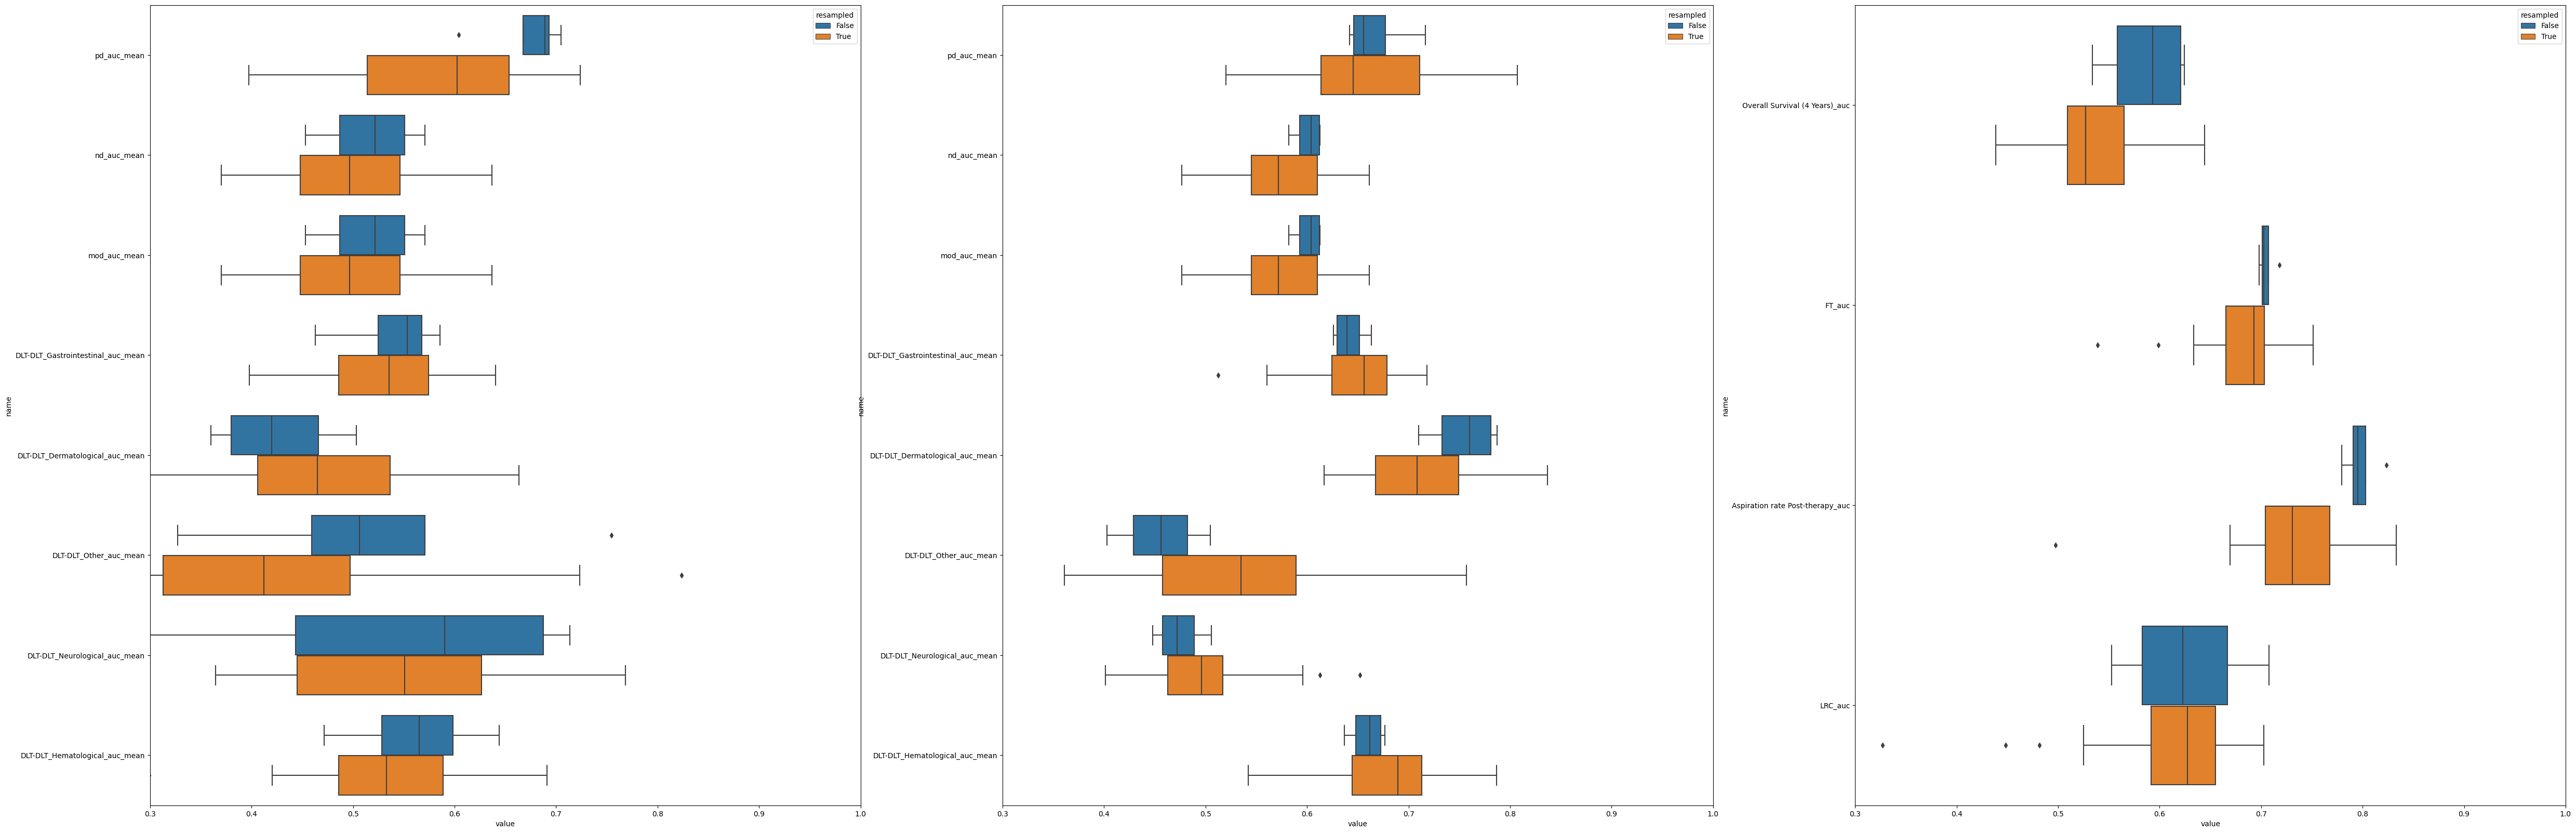

In [6]:
def unravel_result(res):
    res = format_main_result(res,as_df=False)
    r2 = {}
    for key,value in res.items():
        for key2, value2 in value.items():
            r2[key+'_'+key2] = value2
    return r2

import seaborn as sns
import matplotlib.pyplot as plt
def vis_ensemble_results(resultlist,ax=None):
    plotstuff = []
    for r in resultlist[1]:
        rr = unravel_result(r)
        for k,v in rr.items():
            entry = {'name': k,'value': v,'resampled': False}
            plotstuff.append(entry)
    for r in resultlist[-1]:
        rr = unravel_result(r)
        for k,v in rr.items():
            entry = {'name': k,'value': v,'resampled': True}
            plotstuff.append(entry)
#     plotstuff = [v for v in plotstuff if 'accuracy' not in v['name'] and 'mse' not in v['name']]
    plotstuff = [v for v in plotstuff if 'auc_mean' in v['name'] or v['name'][len(v['name'])-3:] == 'auc']
    tempdf = pd.DataFrame(plotstuff)
    if ax is None:
        fig,ax = plt.subplots(1,1,figsize=(10,10))
    sns.boxplot(
        data=tempdf,
        orient='h',
        hue='resampled',
        x='value',
        y='name',
        ax=ax,
    )
    ax.set_xlim(.3,1)
fig,axes = plt.subplots(1,3,figsize=(60,20))
for i,model in enumerate([transition_model1,transition_model2,outcome_model]):
    results = evaluate_ensemble(model,i+1,dataset=dataset)
    vis_ensemble_results(results,ax=axes[i])

In [20]:
def calc_optimal_decisions(dataset,ids,m1,m2,m3,weights=[-1,1,1,-1],outcome_loss_func=None,get_transitions=True):
    m1.eval()
    m2.eval()
    m3.eval()
    device = m1.get_device()
    data = dataset.processed_df.copy().loc[ids]
    
    def get_dlt(state):
        if state == 2:
            return data[Const.dlt2].copy()
        d = data[Const.dlt1].copy()
        if state < 1:
            d.values[:,:] = 0
        return d
    
    def get_pd(state):
        if state == 2:
            return data[Const.primary_disease_states2].copy()
        d = data[Const.primary_disease_states].copy()
        if state < 1:
            d.values[:,:] = 0
        return d
    
    def get_nd(state):
        if state == 2:
            return data[Const.nodal_disease_states2].copy()
        d = data[Const.nodal_disease_states].copy()
        if state < 1:
            d.values[:,:] = 0
        return d
    
    def get_cc(state):
        res = data[Const.ccs].copy()
        if state == 1:
            res.values[:,:] = np.zeros(res.values.shape)
        return res
    
    def get_mod(state):
        res = data[Const.modifications].copy()
        #this should have an ic condition but we don't use it anumore anywa
        return res
        
    def formatdf(d):
        d = df_to_torch(d).to(device)
        return d
    
    
    outcomedf = data[Const.outcomes]
    baseline = dataset.get_state('baseline').loc[ids]
    baseline_input = formatdf(baseline)

    
    def outcome_loss(ypred):
        l = torch.mul((-1*(ypred[:,0] - 1)),-weights[0])
        for i,weight in enumerate(weights[1:]):
            #weights with negative values will invert the outcome so e.g. Regional control becomes no regional control
            #so the penaly is correct
            if weight > 0:
                newloss = torch.mul(ypred[:,i],weight)
            else:
                newloss = torch.mul(-1*(ypred[:,i] - 1),-weights[i])
            l = torch.add(l,newloss)
        return l
    if outcome_loss_func is None:
        outcome_loss_func = outcome_loss
    
    cat = lambda x: torch.cat([xx.to(device) for xx in x],axis=1).to(device)
    format_transition = lambda x: x.to(device)
    
    def get_outcome(d1,d2,d3):
        d1 = torch.full((len(ids),1),d1).type(torch.FloatTensor)
        d2 = torch.full((len(ids),1),d2).type(torch.FloatTensor)
        d3 = torch.full((len(ids),1),d3).type(torch.FloatTensor)
        
        tinput1 = cat([baseline_input,d1])
        ytransition = m1(tinput1)
        [ypd1,ynd1,ymod,ydlt1] = [format_transition(xx) for xx in ytransition['predictions']]
        d1_thresh = torch.gt(d1,.5).view(-1,1).to(device)
        ypd1[:,0:2] = ypd1[:,0:2]*d1_thresh
        ynd1[:,0:2] = ynd1[:,0:2]*d1_thresh
        
        tinput2 = cat([baseline_input,ypd1,ynd1,ymod,ydlt1,d1,d2])
        ytransition2 = m2(tinput2)
        [ypd2,ynd2,ycc,ydlt2] = [format_transition(xx) for xx in ytransition2['predictions']]
        
        input3 = cat([baseline_input, ypd2, ynd2, ycc, ydlt2, d1, d2,d3])
        outcome = m3(input3)['predictions']
        transitions = {
            'pd1': ypd1,
            'nd1': ynd1,
            'nd2': ynd2,
            'pd2': ypd2,
            'mod': ymod,
            'cc': ycc,
            'dlt1': ydlt1,
            'dlt2': ydlt2,
        }
        return outcome, transitions

    losses = []
    loss_order = []
    transitions = {}
    for d1 in [0,1]:
        for d2 in [0,1]:
            for d3 in [0,1]:
                outcomes, transition_entry = get_outcome(d1,d2,d3)
                loss = outcome_loss_func(outcomes)
                losses.append(loss)
                loss_order.append([d1,d2,d3])
                transitions[str(d1)+str(d2)+str(d3)] = transition_entry
    losses = torch.stack(losses,axis=1)
    optimal_decisions = [loss_order[i] for i in torch.argmin(losses,axis=1)]
    result = torch.tensor(optimal_decisions).type(torch.FloatTensor)
    if get_transitions:
        opt_transitions = {k: torch.zeros(v.shape).type(torch.FloatTensor) for k,v in transitions['000'].items()}
        for i,od in enumerate(optimal_decisions):
            key = ''.join([str(o) for o in od])
            entry = transitions[key]
            for kk,vv in entry.items():
                opt_transitions[kk][i,:] = vv[i,:]
        return result, opt_transitions
    return result

def eval_decision_model(model,tmodel1,tmodel2,tmodel3,dataset=None):
    if dataset is None:
        dataset = DTDataset()
        
    data = dataset.processed_df.copy()
    
    train_ids, test_ids = get_tt_split(dataset)

    def get_dlt(state):
        if state == 2:
            return data[Const.dlt2].copy()
        d = data[Const.dlt1].copy()
        if state < 1:
            d.values[:,:] = 0
        return d
    
    def get_pd(state):
        if state == 2:
            return data[Const.primary_disease_states2].copy()
        d = data[Const.primary_disease_states].copy()
        if state < 1:
            d.values[:,:] = 0
        return d
    
    def get_nd(state):
        if state == 2:
            return data[Const.nodal_disease_states2].copy()
        d = data[Const.nodal_disease_states].copy()
        if state < 1:
            d.values[:,:] = 0
        return d
    
    def get_cc(state):
        res = data[Const.ccs].copy()
        if state == 1:
            res.values[:,:] = np.zeros(res.values.shape)
        return res
    
    def get_mod(state):
        res = data[Const.modifications].copy()
        #this should have an ic condition but we don't use it anumore anywa
        return res
        
    outcomedf = data[Const.outcomes]
    baseline = dataset.get_state('baseline')
    
    def formatdf(d,dids=train_ids):
        d = df_to_torch(d.loc[dids]).to(model.get_device())
        return d
    
    def remove_decisions(df):
        cols = [c for c in df.columns if c not in Const.decisions ]
        ddf = df[cols]
        return ddf
    
    makeinput = lambda step,dids: df_to_torch(remove_decisions(dataset.get_input_state(step=step,ids=dids)))
    
    y = df_to_torch(outcomedf.loc[test_ids])
    xxtrained = [baseline, get_dlt(0),get_dlt(0),get_pd(0),get_nd(0),get_cc(0),get_mod(0)]
    xxtrain = [formatdf(xx,test_ids) for xx in xxtrained]
    
    usemem = hasattr(model,'memory')
    if usemem:
        o1 = model(torch.cat(xxtrain,axis=1),position=0,use_saved_memory = True)
    else:
        o1 = model(torch.cat(xxtrain,axis=1),position=0)
    decision1_imitation = o1[:,3]
    
    x1_imitation = [baseline, get_dlt(1),get_dlt(0),get_pd(1),get_nd(1),get_cc(1),get_mod(1)]
    x1_imitation = [formatdf(xx1,test_ids) for xx1 in x1_imitation]
    
    if usemem:
        decision2_imitation = model(torch.cat(x1_imitation,axis=1),position=1,use_saved_memory = True)[:,4]
    else:
        decision2_imitation = model(torch.cat(x1_imitation,axis=1),position=1)[:,4]
        
    x2_imitation = [baseline, get_dlt(1),get_dlt(2),get_pd(2),get_nd(2),get_cc(2),get_mod(2)]
        
    x2_imitation = [formatdf(xx2,test_ids) for xx2 in x2_imitation]
    
    if usemem:
        decision3_imitation = model(torch.cat(x2_imitation,axis=1),position=2,use_saved_memory = True)[:,5]
    else:
        decision3_imitation = model(torch.cat(x2_imitation,axis=1),position=2)[:,5]
    
        
    y_opt, transition_dict = calc_optimal_decisions(dataset,test_ids,tmodel1,tmodel2,tmodel3)
    decision1_opt = o1[:,0]
    
    opt_input2 = [
            formatdf(baseline,test_ids), 
            transition_dict['dlt1'],
            formatdf(get_dlt(0),test_ids),
            transition_dict['pd1'],
            transition_dict['nd1'], 
            formatdf(get_cc(0),test_ids),
            transition_dict['mod']
                 ]
    opt_input2 = torch.cat(opt_input2,axis=1)
    if usemem:
        decision2_opt = model(opt_input2,position=1,use_save_memory=True)[:,1]
    else:
        decision2_opt = model(opt_input2,position=1)[:,1]
    opt_input3 = [
            formatdf(baseline,test_ids),
            transition_dict['dlt1'],
            transition_dict['dlt2'],
            transition_dict['pd2'],
            transition_dict['nd2'],
            transition_dict['cc'],
            transition_dict['mod'],
        ]
    opt_input3 = torch.cat(opt_input3,axis=1)
    if usemem:
        decision3_opt = model(opt_input3,position=2,use_saved_memory=True)[:,2]
    else:
        decision3_opt = model(opt_input3,position=2)[:,2]
    
    scores = []
    imitation = [decision1_imitation,decision2_imitation,decision3_imitation]
    optimal = [decision1_opt,decision2_opt,decision3_opt]
    for i,decision_im in enumerate(imitation):
        deci = decision_im.cpu().detach().numpy()
        deci0 = (deci > .5).astype(int)
        iout = y[:,i].cpu().detach().numpy()
        acci = accuracy_score(iout,deci0)
        try:
            auci = roc_auc_score(iout,deci)
        except:
            auci = -1

        deco = optimal[i].cpu().detach().numpy()
        deci0 = (deco > .5).astype(int)
        oout = y_opt[:,i].cpu().detach().numpy()
        acco = accuracy_score(oout,deci0)
        try:
            auco = roc_auc_score(oout,deco)
        except:
            auco=-1
        scores.append({'decision': i,'optimal_auc': auco,'imitation_auc': auci,'optimal_acc': acco,'imitation_acc': acci})
    return scores

eval_decision_model(decision_model,transition_model1,transition_model2,outcome_model)

[{'decision': 0,
  'optimal_auc': 0.9575381679389312,
  'imitation_auc': 0.5858778625954199,
  'optimal_acc': 0.9387755102040817,
  'imitation_acc': 0.8979591836734694},
 {'decision': 1,
  'optimal_auc': -1,
  'imitation_auc': 0.6760869565217392,
  'optimal_acc': 1.0,
  'imitation_acc': 0.7959183673469388},
 {'decision': 2,
  'optimal_auc': 0.9649280575539568,
  'imitation_auc': 0.7981563890654799,
  'optimal_acc': 0.9591836734693877,
  'imitation_acc': 0.8231292517006803}]

In [8]:

def baseline_mc_metrics(yt,yp):
    #this is a catch for when I se the dlt prediction format (encoded integer ordinal, predict as a categorical and take the argmax)
    try:
        bacc = balanced_accuracy_score(yt,np.argmax(yp,axis=1))
    except Exception as e:
        print('bacc',e)
        bacc = -1
    try:
        roc_micro = roc_auc_score(yt,yp,average='macro',multi_class='ovr')
    except Exception as e:
        print('micro',e)
        roc_micro = -1
    try:
        roc_macro = roc_auc_score(yt,yp,average='macro',multi_class='ovr')
    except Exception as e:
        print('macro',e)
        roc_macro = -1
    try:
        roc_weighted = roc_auc_score(yt,yp,average='weighted',multi_class='ovr')
    except Exception as e:
        print('weighted',e)
        roc_weighted= -1
    return {'accuracy': bacc,'auc_micro':roc_micro,'auc_mean':roc_macro,'auc_weighted':roc_weighted}
    
def mc_svc_baseline(dataset,outcome='pd_states1',class_weight='balanced',**svc_args):
    state = 0
    if outcome in ['pd_states1','nd_states1']:
        state = 1
    elif outcome in ['pd_states2','nd_states2']:
        state = 2
    else:
        print('nope')
        return
    train_ids, test_ids = get_tt_split(dataset)
    xtrain = dataset.get_input_state(step=state,ids=train_ids)
    xtest = dataset.get_input_state(step=state,ids=test_ids)
    ytrain = dataset.get_state(outcome,ids=train_ids)
    ytest= dataset.get_state(outcome,ids=test_ids)
    ytrain = np.argmax(ytrain.values,axis=1)
    ytest = np.argmax(ytest.values,axis=1)
        
    normalize = lambda x: (x - xtrain.values.mean(axis=0))/(xtrain.values.std(axis=0)+.0001)
    model = SVC(**svc_args,probability=True,class_weight=class_weight,random_state=0)
    model = model.fit(xtrain,ytrain)
    ypred= model.predict_proba(xtest)
    return baseline_mc_metrics(ytest,ypred)

def eval_svcs_progression(dataset,**args):
    res = {}
    for state in [1,2]:
        for outcome in ['pd','nd']:
            name = outcome+'_states'+str(state)
            results = mc_svc_baseline(dataset,outcome=outcome+'_states'+str(state),**args)
            res[outcome+str(state)] = results
    return res

eval_svcs_progression(dataset, kernel='linear', class_weight='balanced')

{'pd1': {'accuracy': 0.45759103641456583,
  'auc_micro': 0.8397712636967355,
  'auc_mean': 0.8397712636967355,
  'auc_weighted': 0.9018325128646307},
 'nd1': {'accuracy': 0.6336633663366337,
  'auc_micro': 0.8938885178930379,
  'auc_mean': 0.8938885178930379,
  'auc_weighted': 0.9273717569525023},
 'pd2': {'accuracy': 0.3333333333333333,
  'auc_micro': 0.5531864252611799,
  'auc_mean': 0.5531864252611799,
  'auc_weighted': 0.6030935647200405},
 'nd2': {'accuracy': 0.35793573515092497,
  'auc_micro': 0.5730755857932152,
  'auc_mean': 0.5730755857932152,
  'auc_weighted': 0.5310578838581503}}

In [44]:
dataset.processed_df[Const.dlt1[0]]

id
3        0.0
5        0.0
6        0.0
7        0.0
8        0.0
        ... 
10201    0.0
10202    0.0
10203    0.0
10204    0.0
10205    0.0
Name: DLT_Vascular, Length: 536, dtype: float64

In [42]:
Const.dlt1

['DLT_Vascular',
 'DLT_Gastrointestinal',
 'DLT_Dermatological',
 'DLT_Other',
 'DLT_Nephrological',
 'DLT_Neurological',
 'DLT_Hematological',
 'DLT_Infection (Pneumonia)']

In [ ]:
def boolean_metrics(yt,yp,yp_bool=None):
    if yp_bool is None:
        yp_bool = yp > .5
    precision, recall, f1, support = precision_recall_fscore_support(yt,yp_bool,pos_label=1,average='binary')
    auc = roc_auc_score(yt,yp)
    return {'auc': auc, 'f1': f1, 'precision': precision, 'recall':recall}

def boolean_outcomes(dataset,model = None,**model_args):
    if model is None:
        model = SVC(probability=True,random_state=0,**model_args)
    targets = ['decision1','decision2','decision3','survival','ft','aspiration','lr_control']
    train_ids, test_ids = get_tt_split(dataset)
    results = {}
    
    def run_target(xtrain,xtest,ytrain,ytest):
        model.fit(xtrain,ytrain)
        ypred = model.predict_proba(xtest)[:,1]
        ypred_bool = model.predict(xtest)
        metrics = boolean_metrics(ytest,ypred,ypred_bool)
        return metrics
    
    for target in targets:
        state = 3
        if target == 'decision1':
            state = 0
        elif target == 'decision2':
            state = 1
        elif target == 'decision3':
            state = 2
        xtrain = dataset.get_input_state(step=state,ids=train_ids)
        xtest = dataset.get_input_state(step=state,ids=test_ids)
        ytrain = dataset.get_state(target,ids=train_ids)
        ytest= dataset.get_state(target,ids=test_ids)
        results[target] = run_target(xtrain,xtest,ytrain,ytest)
        
    for target in Const.dlt1 + Const.dlt2:
        state = 0 if target in Const.dlt1 else 1
        xtrain = dataset.get_input_state(step=state,ids=train_ids)
        xtest =  dataset.get_input_state(step=state,ids=test_ids)
        y = dataset.processed_df[target]
        ytrain = y.loc[train_ids]
        ytest = y.loc[test_ids]
        if ytrain.sum() > 0 and ytest.sum() > 0:
            results[target] = run_target(xtrain,xtest,ytrain,ytest)
    return results

boolean_outcomes(dataset,class_weight='balanced')
svc_results = []
for kernel in ['linear','rbf','poly']:
    results = boolean_outcomes(dataset,class_weight='balanced',kernel=kernel)
    for k,v in results.items():
        entry = {kk:vv for kk,vv in v.items()}
        entry['outcome'] = k
        entry['model'] ='svc-' + kernel
        svc_results.append(entry)
print('svc done')
for n in [1,10,100,500]:
    for max_depth in [4,10]:
        for min_split in [2,5]:
            for criterion in ['gini','log_loss']:
                model = RandomForestClassifier(n_estimators=n,max_depth = max_depth,min_samples_split=min_split,class_weight='balanced',random_state=0)
                results = boolean_outcomes(dataset,model=model)
                for k,v in results.items():
                    entry = {kk:vv for kk,vv in v.items()}
                    entry['outcome'] = k
                    entry['model'] ='tree-'+criterion+'-' +str(n) + '-'+'depth:'+str(max_depth)+'-minsplit:'+str(min_split)
                    svc_results.append(entry)
    model2 = MLPClassifier(hidden_layer_sizes=n,random_state=0,early_stopping=True,solver='adam')
    results = boolean_outcomes(dataset,model=model2)
    for k,v in results.items():
        entry = {kk:vv for kk,vv in v.items()}
        entry['outcome'] = k
        entry['model'] ='mlp-' +str(n)
        svc_results.append(entry)
svc_results = pd.DataFrame(svc_results)

svc done


In [ ]:
fig,ax = plt.subplots(1,1,figsize=(15,35))
sns.barplot(
    data=svc_results,
    y='outcome',
    hue='model',
    x='auc',
    orient='h',
)

In [ ]:
best_models = {}
for outcome, subdf in svc_results.groupby('outcome'):
    best = subdf[subdf.auc == subdf.auc.max()].iloc[0]
    best_models[outcome] = best.to_dict()
best_models